## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
import re
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from xgboost import XGBRegressor
from math import sqrt
#Make help functions easier to read.
%config InteractiveShell.ast_node_interactivity = "all"

/tmp/ipykernel_417643/28811212.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Lable Data

In [2]:
df1 = pd.read_csv('Data/labels/permeability/204_20_1.csv')
df1Z = pd.read_csv('Data/labels/permeability/204_20_1Z.csv')
df2 = pd.read_csv('Data/labels/permeability/204_20_2.csv')
df3 = pd.read_csv('Data/labels/permeability/204_20_3.csv')
df6 = pd.read_csv('Data/labels/permeability/204_24a_6.csv')
df6A = pd.read_csv('Data/labels/permeability/204_20_6A.csv')
df7 = pd.read_csv('Data/labels/permeability/204_19_7.csv')
df7_20A = pd.read_csv('Data/labels/permeability/204_20a_7.csv')
df7_24A = pd.read_csv('Data/labels/permeability/204_24a_7.csv')

#### Wireline Log Data

In [3]:
W19_3 = pd.read_csv('csv_wireline_logs/well_204_19_3A.csv')
W19_6 = pd.read_csv('csv_wireline_logs/well_204_19_6.csv')
W19_7 = pd.read_csv('csv_wireline_logs/well_204_19_7.csv')
W1 = pd.read_csv('csv_wireline_logs/well_204_20_1.csv')
W1Z = pd.read_csv('csv_wireline_logs/well_204_20_1Z.csv')
W2 = pd.read_csv('csv_wireline_logs/well_204_20_2.csv')
W3 = pd.read_csv('csv_wireline_logs/well_204_20_3.csv')
W6a = pd.read_csv('csv_wireline_logs/well_204_20_6a.csv')
W6 = pd.read_csv('csv_wireline_logs/well_204_24a_6.csv')
W7 = pd.read_csv('csv_wireline_logs/well_204_20a_7.csv')
W7_24A = pd.read_csv('csv_wireline_logs/well_204_24a_7.csv')

## Data Preprocessing

#### Clean special characters in data and merge two datasets

In [4]:
# Function code to clean the data.
def replace_special_characters(value):
    value = str(value)
    result = ''
    i = 0

    while i < len(value):
        # substitute special characters
        match = re.match(r'[0-9.,<>]+', value[i:])
        if match:
            matched_part = match.group()
            result += matched_part
            i += len(matched_part)
        else:
            # if no match, append the character and move on
            i += 1

    # substitude the comma with a dot
    result = result.replace(',', '.')

    # substitude the less than sign with a zero，as it is too small
    result = result.replace('< .01', '0.001').replace('<.01', '0.001')

    return result

#FUNCTION CODE TO MERGE THE TWO WELLS.  THIS WILL BE USED LATER.
def add_well_data_to_df(df, W):
    # Get the list of columns from W19_3 excluding 'DEPTH'
    well_columns = [col for col in W.columns if col != 'DEPTH']
    
    # Add new columns to df1 and initialize with NaN
    for col in well_columns:
        df[col] = np.nan

    # Iterate over each row in df1
    for idx, row in df.iterrows():
        # Find the row in W19_3 with the closest DEPTH
        closest_idx = np.abs(W['DEPTH'] - row['DEPTH']).idxmin()
        closest_row = W.iloc[closest_idx]

        # Update the relevant columns in df1
        for col in well_columns:
            df.at[idx, col] = closest_row[col]

    return df

In [5]:

df3['DEPTH'] = df3['DEPTH'].apply(replace_special_characters)
df3['DEPTH'] = df3['DEPTH'].astype(float)

df6A['DEPTH'] = df6A['DEPTH'].apply(replace_special_characters)
df6A['DEPTH'] = df6A['DEPTH'].astype(float)

df7_20A['DEPTH'] = df7_20A['DEPTH'].apply(replace_special_characters)
df7_20A['DEPTH'] = df7_20A['DEPTH'].astype(float)

df7_24A['DEPTH'] = df7_24A['DEPTH'].apply(replace_special_characters)
df7_24A = df7_24A[df7_24A['DEPTH'] != '']
df7_24A['DEPTH'] = df7_24A['DEPTH'].astype(float)

df7['DEPTH'] = df7['DEPTH'].apply(replace_special_characters)
df7 = df7[df7['DEPTH'] != '']
df7['DEPTH'] = df7['DEPTH'].astype(float)

#### Add well location information

In [6]:
df1['longitude'] = -4.0386472
df1Z['longitude'] = -4.0386472
df2['longitude'] = -4.0585925
df3['longitude'] = -4.0429056
df6['longitude'] = -4.3999889
df6A['longitude'] = -4.0310681
df7['longitude'] = -4.2432231
df7_20A['longitude'] = -4.1381753
df7_24A['longitude'] = -4.2365475

df1['latitude'] = 60.3518389
df1Z['latitude'] = 60.3518389
df2['latitude'] = 60.3465144
df3['latitude'] = 60.4264917
df6['latitude'] = 60.323475
df6A['latitude'] = 60.3958653
df7['latitude'] = 60.3731917
df7_20A['latitude'] = 60.3443039
df7_24A['latitude'] = 60.3305383

#### Data Alignment

In [7]:
## df1 
start_depth = 1945.00
end_depth = 2116.00
df1.loc[(df1['DEPTH'] >= start_depth) & (df1['DEPTH'] <= end_depth), 'DEPTH'] += 3.0

## df1Z
start_depth = 2673.00
end_depth = 2686.46
df1Z.loc[(df1Z['DEPTH'] >= start_depth) & (df1Z['DEPTH'] <= end_depth), 'DEPTH'] += 5.0

## df2
start_depth = 1998.00
end_depth = 2018.55
df2.loc[(df2['DEPTH'] >= start_depth) & (df2['DEPTH'] <= end_depth), 'DEPTH'] += 2.0

## df3
start_depth = 2401.00
end_depth = 2425.75
df3.loc[(df3['DEPTH'] >= start_depth) & (df3['DEPTH'] <= end_depth), 'DEPTH'] -= 1.2
start_depth2 = 2427.50
end_depth2 = 2436.83
df3.loc[(df3['DEPTH'] >= start_depth2) & (df3['DEPTH'] <= end_depth2), 'DEPTH'] -= 2.7
start_depth3 = 2658.00
end_depth3 = 2685.79
df3.loc[(df3['DEPTH'] >= start_depth3) & (df3['DEPTH'] <= end_depth3), 'DEPTH'] += 1.2
start_depth4 = 2958.00
end_depth4 = 2978.15
df3.loc[(df3['DEPTH'] >= start_depth4) & (df3['DEPTH'] <= end_depth4), 'DEPTH'] += 1.6

## df6
df6['DEPTH'] = df6['DEPTH'].apply(replace_special_characters)
df6 = df6[df6['DEPTH'] != '']
df6['DEPTH'] = df6['DEPTH'].astype(float)
start_depth = 2211.00
end_depth = 2230.70
df6.loc[(df6['DEPTH'] >= start_depth) & (df6['DEPTH'] <= end_depth), 'DEPTH'] += 3.5
start_depth2 = 2416.00
end_depth2 = 2429.67
df6.loc[(df6['DEPTH'] >= start_depth2) & (df6['DEPTH'] <= end_depth2), 'DEPTH'] += 2.0
start_depth3 = 2429.67
end_depth3 = 2438.96
df6.loc[(df6['DEPTH'] >= start_depth3) & (df6['DEPTH'] <= end_depth3), 'DEPTH'] += 2.43
start_depth4 = 2440.20
end_depth4 = 2462.93
df6.loc[(df6['DEPTH'] >= start_depth4) & (df6['DEPTH'] <= end_depth4), 'DEPTH'] += 0.8
start_depth5 = 2485.60
end_depth5 = 2493.50
df6.loc[(df6['DEPTH'] >= start_depth5) & (df6['DEPTH'] <= end_depth5), 'DEPTH'] += 0.4

## df7
start_depth = 2131.00
end_depth = 2157.68
df7.loc[(df7['DEPTH'] >= start_depth) & (df7['DEPTH'] <= end_depth), 'DEPTH'] += 1.8
start_depth2 = 2158.00
end_depth2 = 2180.38
df7.loc[(df7['DEPTH'] >= start_depth2) & (df7['DEPTH'] <= end_depth2), 'DEPTH'] += 1.6
start_depth3 = 2540.00
end_depth3 = 2544.89
df7.loc[(df7['DEPTH'] >= start_depth3) & (df7['DEPTH'] <= end_depth3), 'DEPTH'] += 3.0

#df7_24A
start_depth = 2075.00
end_depth = 2102.00
df7_24A.loc[(df7_24A['DEPTH'] >= start_depth) & (df7_24A['DEPTH'] <= end_depth), 'DEPTH'] += 2.2
start_depth2 = 2102.00
end_depth2 = 2127.85
df7_24A.loc[(df7_24A['DEPTH'] >= start_depth2) & (df7_24A['DEPTH'] <= end_depth2), 'DEPTH'] += 2.35
start_depth3 = 2128.50
end_depth3 = 2145.90
df7_24A.loc[(df7_24A['DEPTH'] >= start_depth3) & (df7_24A['DEPTH'] <= end_depth3), 'DEPTH'] += 2.0
start_depth4 = 2146.00
end_depth4 = 2162.60
df7_24A.loc[(df7_24A['DEPTH'] >= start_depth4) & (df7_24A['DEPTH'] <= end_depth4), 'DEPTH'] += 1.8
start_depth5 = 2163.00
end_depth5 = 2179.30
df7_24A.loc[(df7_24A['DEPTH'] >= start_depth5) & (df7_24A['DEPTH'] <= end_depth5), 'DEPTH'] += 1.2
start_depth6 = 2180.00
end_depth6 = 2188.56
df7_24A.loc[(df7_24A['DEPTH'] >= start_depth6) & (df7_24A['DEPTH'] <= end_depth6), 'DEPTH'] += 1.0
start_depth7 = 2189.00
end_depth7 = 2206.92
df7_24A.loc[(df7_24A['DEPTH'] >= start_depth7) & (df7_24A['DEPTH'] <= end_depth7), 'DEPTH'] += 0.85
start_depth8 = 2208.50
end_depth8 = 2240.65
df7_24A.loc[(df7_24A['DEPTH'] >= start_depth8) & (df7_24A['DEPTH'] <= end_depth8), 'DEPTH'] += 0.2

#### Add the wireline log data to well core data

In [8]:
df1_updated = add_well_data_to_df(df1, W1)
df1Z_updated = add_well_data_to_df(df1Z, W1Z)
df2_updated = add_well_data_to_df(df2, W2)
df3_updated = add_well_data_to_df(df3, W3)
df6_updated = add_well_data_to_df(df6, W6)
df6A_updated = add_well_data_to_df(df6A, W6a)
df7_updated = add_well_data_to_df(df7, W19_7)
df7_20A_updated = add_well_data_to_df(df7_20A, W7)
df7_24A_updated = add_well_data_to_df(df7_24A, W7_24A)

#### Put all the updated data together into single data set and drop empty calue

In [9]:
df_final = pd.concat([df1_updated, df1Z_updated, df2_updated, df3_updated, df6_updated, df6A_updated, df7_updated, df7_20A_updated, df7_24A_updated], axis=0)
df_final['POROSITY\n(HELIUM)'].replace('2B.3', '28.3', inplace = True)
df_final = df_final.applymap(replace_special_characters)
df_final = df_final.applymap(lambda x: float(x) if x else np.nan)
#Lose the unnamed columns with no data in them from the dataset 
df_final = df_final.dropna(how='all', axis=1) #inplace=True)
df_final = df_final.dropna(subset=['PERMEABILITY (HORIZONTAL)\nKair\nmd'])
df_final

/tmp/ipykernel_417643/483961564.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['POROSITY\n(HELIUM)'].replace('2B.3', '28.3', inplace = True)
/tmp/ipykernel_417643/483961564.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_final = df_final.applymap(replace_special_characters)
/tmp/ipykernel_417643/483961564.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_final = df_final.applymap(lambda x: float(x) if x else np.nan)


,SAMPLE\nNUMBER,DEPTH,PERMEABILITY (HORIZONTAL)\nKair\nmd,PERMEABILITY(VERTICAL)\nKair\nmd,POROSITY\n(HELIUM),longitude,latitude,CALI,DENC,DENS,...,AT60,RMED,DTS1,DTS2,RACH,RLA2,RLA4,RPCH,DTS_1,DTS_2
1,2.0,1952.20,1057.0,607.0,27.7,4.038647,60.351839,11.9344,0.0221,2.1877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,1956.95,1784.0,1292.0,30.3,4.038647,60.351839,11.9438,0.0135,2.1702,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8.0,1960.53,2909.0,2771.0,30.4,4.038647,60.351839,11.9289,0.0234,2.1427,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10.0,1979.05,1272.0,1089.0,31.3,4.038647,60.351839,11.9648,0.0195,2.1464,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,13.0,1983.05,3706.0,3072.0,30.7,4.038647,60.351839,11.9859,0.0216,2.1484,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,638.0,2238.45,200.0,201.0,25.3,4.236548,60.330538,12.2100,0.0120,2.2957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,177.0708,185.9365
656,640.0,2238.88,306.0,NaN,25.4,4.236548,60.330538,12.1720,0.0149,2.2700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.3234,182.5486
657,641.0,2239.20,113.0,NaN,27.3,4.236548,60.330538,12.1850,0.0159,2.2230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.1859,176.5864
658,642.0,2239.45,356.0,152.0,27.8,4.236548,60.330538,12.2110,0.0149,2.2707,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,177.5526,187.7896


## Exploratory Data Analysis

##### First we looked at the physical significance of each data, where DENC is the corrected value of DENS, so we added the two columns of values to get the exact density value

In [10]:
df_final['DEN_SUM'] = df_final['DENC'] + df_final['DENS']
df_final = df_final.drop(columns=['DENC', 'DENS'])

##### We then looked at the number of nulls for each type of logging data

In [11]:
df_final['CALI'].isnull().sum(), df_final['DEN_SUM'].isnull().sum() , df_final['GR'].isnull().sum(), df_final['NEUT'].isnull().sum(), df_final['PEF'].isnull().sum(), df_final['RDEP'].isnull().sum(), df_final['RSHAL'].isnull().sum()
df_final['RMED'].isnull().sum(), df_final['DTS1'].isnull().sum(), df_final['DTS2'].isnull().sum(), df_final['RACH'].isnull().sum(), df_final['RMIC'].isnull().sum(), df_final['SP'].isnull().sum(), df_final['AT20'].isnull().sum() 
df_final['AT60'].isnull().sum(), df_final['RLA2'].isnull().sum(), df_final['RLA4'].isnull().sum(), df_final['RPCH'].isnull().sum(), df_final['DTS_1'].isnull().sum(), df_final['DTS_2'].isnull().sum(), df_final['DTS'].isnull().sum()

(0, 0, 0, 0, 0, 0, 0)

(1046, 829, 829, 1144, 98, 584, 1265)

(1214, 1144, 1144, 1144, 1008, 1008, 436)

##### From the above, we can see that some of the columns listed above are missing far too much data. So we should drop the columns which miss too much data and look at the data again.

In [12]:
df_final.drop(columns=['RMED', 'DTS1', 'DTS2', 'RACH', 'RLA2', 'RLA4', 'RPCH', 'DTS_1', 'DTS_2',  'AT20', 'AT60', 'DTS'], axis=1, inplace=True)

In [13]:
df_final

,SAMPLE\nNUMBER,DEPTH,PERMEABILITY (HORIZONTAL)\nKair\nmd,PERMEABILITY(VERTICAL)\nKair\nmd,POROSITY\n(HELIUM),longitude,latitude,CALI,DTC,GR,NEUT,PEF,RDEP,RMIC,RSHAL,SP,DEN_SUM
1,2.0,1952.20,1057.0,607.0,27.7,4.038647,60.351839,11.9344,104.0000,41.1962,0.3138,2.7971,74.4807,1.7281,41.4472,256.9375,2.2098
4,5.0,1956.95,1784.0,1292.0,30.3,4.038647,60.351839,11.9438,107.7000,43.2719,0.3355,2.8726,141.0012,1.0881,47.5833,246.8750,2.1837
7,8.0,1960.53,2909.0,2771.0,30.4,4.038647,60.351839,11.9289,105.7500,49.3563,0.3467,2.7623,56.1015,1.2762,37.4568,250.0000,2.1661
9,10.0,1979.05,1272.0,1089.0,31.3,4.038647,60.351839,11.9648,108.9000,49.1178,0.3357,2.7445,19.3427,3.8349,14.3229,239.5000,2.1659
12,13.0,1983.05,3706.0,3072.0,30.7,4.038647,60.351839,11.9859,106.4500,49.1930,0.3774,3.0419,68.9140,1.2188,48.2487,240.8125,2.1700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,638.0,2238.45,200.0,201.0,25.3,4.236548,60.330538,12.2100,91.3316,68.9447,0.3023,2.7188,2.5315,1.6004,2.1681,NaN,2.3077
656,640.0,2238.88,306.0,NaN,25.4,4.236548,60.330538,12.1720,92.2292,67.7681,0.2849,2.6188,2.5637,1.2023,2.1784,NaN,2.2849
657,641.0,2239.20,113.0,NaN,27.3,4.236548,60.330538,12.1850,95.1692,59.5515,0.2823,2.5638,2.2873,1.2291,1.9654,NaN,2.2389
658,642.0,2239.45,356.0,152.0,27.8,4.236548,60.330538,12.2110,96.4898,72.5625,0.3146,3.1496,2.0822,0.9146,1.8212,NaN,2.2856


#### Feature engineering

##### Find the correlation using heatmap and geological features 

<Figure size 1200x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Heatmap of df_final')

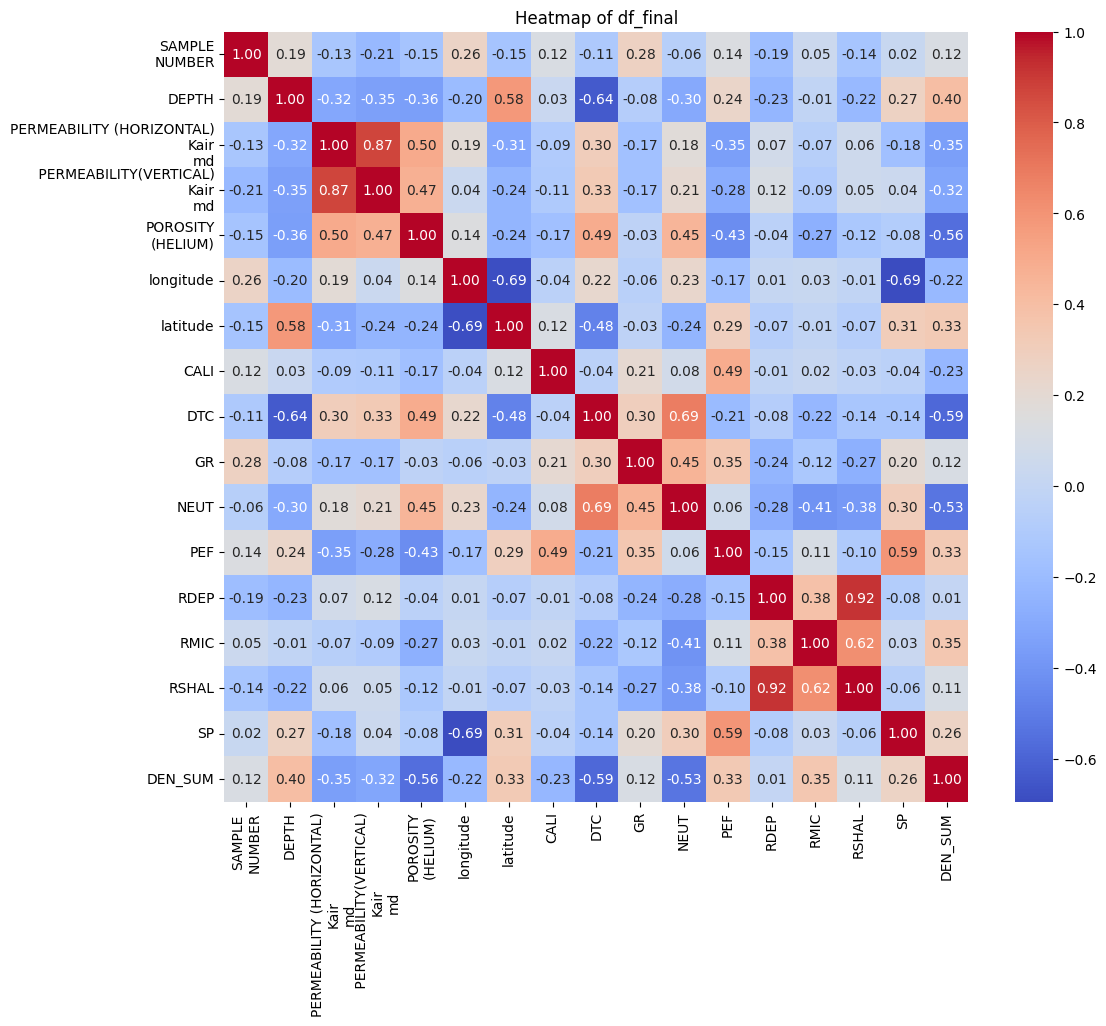

In [14]:
# Calculate the correlation matrix
corr = df_final.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Heatmap of df_final")
plt.show()

##### Commentary on heatmap

###### Looking at the heatmap we can see that the correlation between DTC and NEUT, as well as the correlation between RDEP RMIC and RDEP, are both high. 

###### We chose DTC and RDEP, because DTC is more relevant to rock permeability as it reflects the porosity and structure of the rock by measuring the propagation speed of sound waves through the rock, and these features directly affect the permeability. RDEP, on the other hand, measures the resistivity of the rock at greater depths, which is generally more representative of the overall reservoir properties as it is less affected by disturbances near the borehole

###### 'CALI' denotes the well diameter, which is not related to permeability and is therefore dropped

###### Since SP contains null values, which can negatively affect the final results, we finally selected 'DEPTH', 'POROSITY\n(HELIUM)', 'latitude', 'DEN_SUM', 'DTC', 'GR', 'PEF', 'RDEP' as the feature used to predict the permeability. Drop other features.

In [15]:
df_final = df_final.drop(columns=['NEUT', 'RMIC', 'RSHAL', 'CALI', 'longitude'])

###### Next, the histograms of the selected features are plotted to further analyse the individual features.

(array([  3.,   2.,   1.,   1.,  15., 524., 493., 204.,  38.,  31.]),
 array([1.6184 , 1.72462, 1.83084, 1.93706, 2.04328, 2.1495 , 2.25572,
        2.36194, 2.46816, 2.57438, 2.6806 ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Histogram of DEN_SUM')

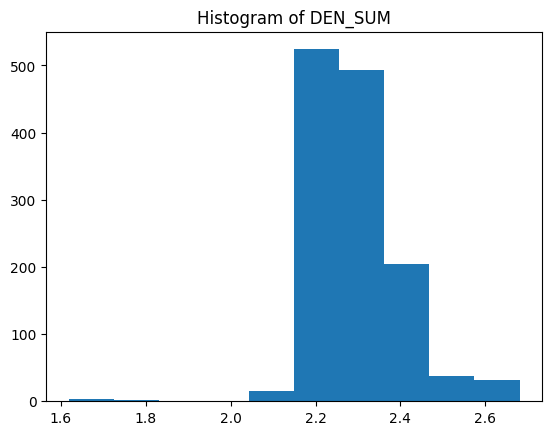

(array([ 20.,  15.,  45., 119., 166., 309., 551.,  81.,   5.,   1.]),
 array([ 55.2202 ,  62.63318,  70.04616,  77.45914,  84.87212,  92.2851 ,
         99.69808, 107.11106, 114.52404, 121.93702, 129.35   ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Histogram of DTC')

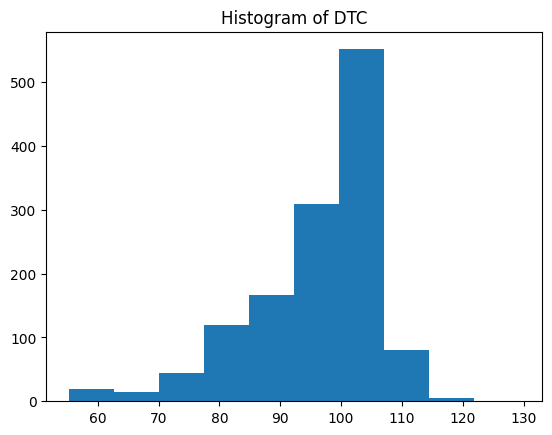

(array([ 13.,  41., 129., 371., 306., 152., 117., 110.,  50.,  23.]),
 array([31.2926 , 37.67598, 44.05936, 50.44274, 56.82612, 63.2095 ,
        69.59288, 75.97626, 82.35964, 88.74302, 95.1264 ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Histogram of GR')

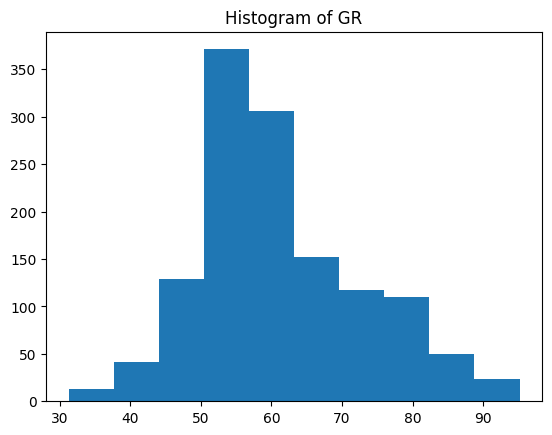

(array([147., 760., 334.,  55.,   7.,   3.,   1.,   2.,   0.,   3.]),
 array([1.8395 , 2.49719, 3.15488, 3.81257, 4.47026, 5.12795, 5.78564,
        6.44333, 7.10102, 7.75871, 8.4164 ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Histogram of PEF')

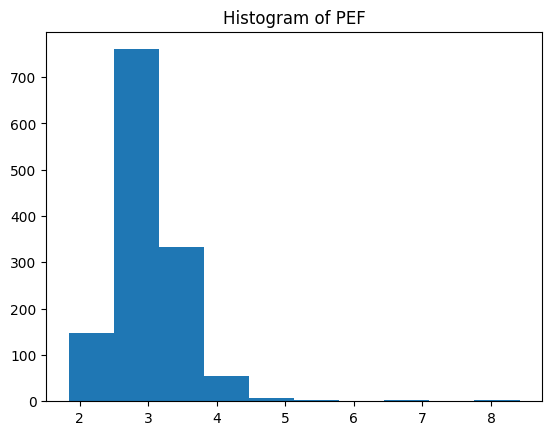

(array([1.199e+03, 7.400e+01, 2.600e+01, 9.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([  0.8048 ,  67.30404, 133.80328, 200.30252, 266.80176, 333.301  ,
        399.80024, 466.29948, 532.79872, 599.29796, 665.7972 ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Histogram of RDEP')

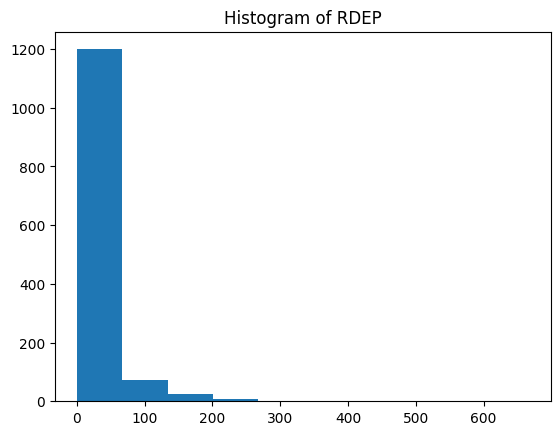

In [16]:
plt.hist(df_final['DEN_SUM'])
plt.title('Histogram of DEN_SUM')
plt.show()
plt.hist(df_final['DTC'])
plt.title('Histogram of DTC')
plt.show()
plt.hist(df_final['GR'])
plt.title('Histogram of GR')
plt.show()
plt.hist(df_final['PEF'])
plt.title('Histogram of PEF')
plt.show()
plt.hist(df_final['RDEP'])
plt.title('Histogram of RDEP')
plt.show()

###### From the histogram, it can be seen that 'GR' and 'RDEP' contain more extreme values and are unevenly distributed, so they need to be logarithmically valued

In [17]:
 #Take logs of the selected features
df_final['log_GR'] = np.log(df_final['GR'])
df_final['log_RDEP'] = np.log(df_final['RDEP'])
df_final = df_final.drop(columns=['GR', 'RDEP'])

In [18]:
df_final

,SAMPLE\nNUMBER,DEPTH,PERMEABILITY (HORIZONTAL)\nKair\nmd,PERMEABILITY(VERTICAL)\nKair\nmd,POROSITY\n(HELIUM),latitude,DTC,PEF,SP,DEN_SUM,log_GR,log_RDEP
1,2.0,1952.20,1057.0,607.0,27.7,60.351839,104.0000,2.7971,256.9375,2.2098,3.718346,4.310540
4,5.0,1956.95,1784.0,1292.0,30.3,60.351839,107.7000,2.8726,246.8750,2.1837,3.767503,4.948768
7,8.0,1960.53,2909.0,2771.0,30.4,60.351839,105.7500,2.7623,250.0000,2.1661,3.899065,4.027163
9,10.0,1979.05,1272.0,1089.0,31.3,60.351839,108.9000,2.7445,239.5000,2.1659,3.894221,2.962315
12,13.0,1983.05,3706.0,3072.0,30.7,60.351839,106.4500,3.0419,240.8125,2.1700,3.895751,4.232859
...,...,...,...,...,...,...,...,...,...,...,...,...
654,638.0,2238.45,200.0,201.0,25.3,60.330538,91.3316,2.7188,NaN,2.3077,4.233305,0.928812
656,640.0,2238.88,306.0,NaN,25.4,60.330538,92.2292,2.6188,NaN,2.2849,4.216092,0.941452
657,641.0,2239.20,113.0,NaN,27.3,60.330538,95.1692,2.5638,NaN,2.2389,4.086841,0.827372
658,642.0,2239.45,356.0,152.0,27.8,60.330538,96.4898,3.1496,NaN,2.2856,4.284448,0.733425


## Model

##### First we selected relevant columns, dropped rows with missing values in the specified columns, and splitted data into training, validation set and test set

In [19]:
df = df_final

# Selecting relevant columns
features = ['DEPTH', 'POROSITY\n(HELIUM)', 'DEN_SUM', 'DTC', 'log_GR', 'PEF', 'log_RDEP', 'latitude']
target = 'PERMEABILITY (HORIZONTAL)\nKair\nmd'

# Dropping rows with missing values in the specified columns
df.dropna(subset=features + [target], inplace=True)

# Splitting data into training+validation set and test set
X = df[features]
y = df[target]
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further splitting training+validation set into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

##### Next we tried different models, including 'XGBoost', 'Random Forest', 'Linear Regression', and 'Support Vector Machine'

In [20]:
# Defining different models
models = {
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror'),
    'Random Forest': RandomForestRegressor(),
    'Linear Regression': LinearRegression(),
    'Support Vector Machine': SVR()
}

# Training, validating, and testing each model
for name, model in models.items():
    # Training the model
    model.fit(X_train, y_train)
    
    # Evaluating on the validation set
    y_val_pred = model.predict(X_val)
    val_rmse = sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)
    print(f"{name} - Validation:\n RMSE: {val_rmse}, R²: {val_r2}\n")
    
    # Evaluating on the test set
    y_test_pred = model.predict(X_test)
    test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    print(f"{name} - Test:\n RMSE: {test_rmse}, R²: {test_r2}\n")

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

XGBoost - Validation:
 RMSE: 364.2572531687722, R²: 0.5249324765163906

XGBoost - Test:
 RMSE: 362.3964090029319, R²: 0.6373123644580316



RandomForestRegressor()

Random Forest - Validation:
 RMSE: 348.47010334207613, R²: 0.5652195837808542

Random Forest - Test:
 RMSE: 365.5332305194115, R²: 0.6310065064042942



LinearRegression()

Linear Regression - Validation:
 RMSE: 451.48786893620706, R²: 0.2701542270194751

Linear Regression - Test:
 RMSE: 506.7956894030501, R²: 0.29069862192282636



SVR()

Support Vector Machine - Validation:
 RMSE: 543.9810934136103, R²: -0.05951360294793506

Support Vector Machine - Test:
 RMSE: 628.6568189433599, R²: -0.09142083549014579



##### Observing the above results, it can be seen that XGBoost and Random Forest model give better results, while Linear Regression and SVR give poor results

##### Both XGBoost and Random Forest showed good predictive power on both validation and test sets, so we decided to use both as the basis for the stacked model. Although both XGBoost and Random Forest are decision tree-based algorithms, they differ in how they construct the tree and process the data.XGBoost uses gradient boosting, while Random Forest is an integrated approach based on bagging. This difference can help reduce the risk of overfitting and improve the generalisation of the model. We used linear regression as the final estimator because it is a very simple model that can be "balanced" during the stacking process, preventing the model from becoming too complex and causing overfitting, and it is more efficient. At the same time, we add hyperparameter tuning to improve model performance。

In [21]:
param_grid_rf = {
    'rf_model__n_estimators': [100, 200],
    'rf_model__max_depth': [10, 20]
}
param_grid_xgb = {
    'xgb_model__learning_rate': [0.05, 0.3],
    'xgb_model__n_estimators': [100, 300],
    'xgb_model__max_depth': [4, 7],
    'xgb_model__num_parallel_tree': [6, 14],
    'xgb_model__booster': ["gbtree"]
}

#Define pipelines for each model
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf_model', RandomForestRegressor())
])

xgb_pipeline = Pipeline([
    #('scaler', StandardScaler()),
    ('xgb_model', XGBRegressor())
])

#Hyperparameter tuning using GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
rf_best = grid_search_rf.best_estimator_

grid_search_xgb = GridSearchCV(estimator=xgb_pipeline, param_grid=param_grid_xgb, cv=3, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)
xgb_best = grid_search_xgb.best_estimator_

# Define the stacked model with the best estimators
base_models = [
    ('rf_best', rf_best),
    ('xgb_best', xgb_best)
]
meta_model = LinearRegression()
stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Train the stacked model on the training data
stacked_model.fit(X_train, y_train)

# Evaluate the model on the validation set
y_val_pred = stacked_model.predict(X_val)
val_rmse = sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)
print(f"Validation Set - Stacked Model RMSE: {val_rmse}")
print(f"Validation Set - Stacked Model R²: {val_r2}")

# Evaluate the model on the test set
y_pred = stacked_model.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)
print(f"Test Set - Stacked Model RMSE: {test_rmse}")
print(f"Test Set - Stacked Model R²: {test_r2}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf_model', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'rf_model__max_depth': [10, 20],
                         'rf_model__n_estimators': [100, 200]},
             verbose=2)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('xgb_model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None,
                                                     grow_policy=None,
                                                     importance_type=None,
                                                     interaction_constrai...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb_model__booster': ['gbtree'],
                         'xgb_model__learning_rate': [0.05, 0.3],
                         'xgb_model__max_depth': [4, 7],
                         'xgb_model__n_estimators': [100, 300],
                         'xgb_model__num_parallel_tree': [6, 14]},
             verbose=2)

StackingRegressor(estimators=[('rf_best',
                               Pipeline(steps=[('scaler', StandardScaler()),
                                               ('rf_model',
                                                RandomForestRegressor(max_depth=20))])),
                              ('xgb_best',
                               Pipeline(steps=[('xgb_model',
                                                XGBRegressor(base_score=None,
                                                             booster='gbtree',
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             device=None,
                                                             early_stopping_rounds=None,
                                                             enabl...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.05,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=4,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=14,
                                                             random_state=None, ...))]))],
                  final_estimator=LinearRegression())

Validation Set - Stacked Model RMSE: 341.63888677171366
Validation Set - Stacked Model R²: 0.5820988928221495
Test Set - Stacked Model RMSE: 365.4839004710662
Test Set - Stacked Model R²: 0.6311060937310473


##### It can be seen that compared to the above models, the stacked model has the lowest RMSE on the validation set and the R-squared value of the model's test set is closest to that of the validation set. This indicates that the model has strong generalisation ability, low risk of overfitting and is more stable. Therefore, we choose this model as our final model.